In [1]:
## CODE 1s 
!pip3 install numpy jax cvxpy matplotlib


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
## CODE2s 
import numpy as np 
import jax
import jax.numpy as jnp 
import cvxpy as cp 
import matplotlib.pyplot as plt 

In [3]:
## CODE3S 
class DoubleInt: 
    ndim = 7    #(VARIABLE)
    control_dim = 4     #(VARIABLE) 
    def __init__(self):
        self.umin = np.array([-1.0, -1.0, -1.0, 5.0])   # pitch, roll, yaw rate, thrust
        self.umax = np.array([1.0, 1.0, 1.0, 14.0]) 
        self.dt = 0.01 

    def step(self, state, control): 
        return state + self.dt * self(state, control)
    
    def __call__(self, state, control): 
        result = self.open_loop_dynamics(state) + self.control_jacobian(state) @ control 
        return result 
    
    def open_loop_dynamics(self, state): 
        out = np.zeros_like(state)
        out[..., 0] = state[..., 3]
        out[..., 1] = state[..., 4]
        out[..., 2] = state[..., 5]
        out[..., 5] = -9.81
        return out 
    
    def control_jacobian(self,state): 
        out = np.zeros((*state.shape[:-1], self.ndim, self.control_dim))
        out[..., 3, 0] = 9.81
        out[..., 4, 1] = 9.81
        out[..., 6, 2] = 1
        out[..., 5, 3] = 1
        return out 

In [4]:
## CODE4s 
class SimpleCBF: 
    def __init__(self, dynamics): 
        self.dynamics = dynamics

    def vf(self, state): 
        state = jnp.array(state) 
        constraint = 5 - jnp.sqrt(state[0]**2 + state[1]**2 + state[2]**2)
        return constraint 
    
    def grad_vf(self, state): 
        state = jnp.array(state) 
        if np.isclose(state[0]**2 + state[1]**2 + state[2]**2, 0):
            return jnp.zeros(7)
        return jax.grad(self.vf)(state)
        
class SmartCBF(SimpleCBF): 

    def vf(self, state): 
        scaling_factor = 0.64
        state = jnp.array(state)
        constraint = 5 - scaling_factor*(jnp.sqrt(state[0]**2 + state[1]**2 + state[2]**2)) - scaling_factor*(jnp.sqrt(state[3]**2 + state[4]**2 + state[5]**2))
        return constraint 

In [5]:
## CODE5s 
class SafetyFilter: 
    def __init__(self, cbf): 
        self.cbf = cbf 
        self.dynamics = self.cbf.dynamics
        self.gamma = 0.7 #change to 0.4 (softer vs harder)  

    def __call__(self, state, nominal_control):
        vf = self.cbf.vf(state)
        grad_vf = self.cbf.grad_vf(state)
        Lg_v = grad_vf @ self.dynamics.control_jacobian(state) 
        Lf_v = grad_vf @ self.dynamics.open_loop_dynamics(state) 

        u = cp.Variable(nominal_control.shape)
        weights = np.diag([6.0,6.0,4.0,4.0]) #weights to take some proportion of each control input (6,6,0.8,0.8)
        obj = cp.Minimize(cp.quad_form(u - nominal_control, weights))
        constraints = [Lf_v + Lg_v @ u >= -self.gamma * vf] 
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.OSQP, eps_abs=1e-6, eps_rel=1e-6) #need to set the tolerance for the solver; divide by 0 error at some iterations
        if u.value is not None: 
            return u.value, True
        else: 
            return nominal_control, False

In [6]:
## CODE6s 
dynamics = DoubleInt()
cbf = SimpleCBF(dynamics) 
safety_filter = SafetyFilter(cbf) 

In [7]:
## CODE7s 
nominal_control = lambda state: np.clip(
    np.array([
        - 1.0 * (state[0] - 9.0) - 2.0 * state[3],  #kp is the first (prop work with pos), kd is the second (damping vel) 1.0,2.0 
        - 1.0 * (state[1] - 6.0) - 2.0 * state[4],  #kp 0th, 1st, 2nd index  #1.0,2.0
        - 0.4 * state[6] - 0.8,                                             #0.4,0.8
        9.81 - 0.75* (state[2] - 4.0) -1.5 * state[5]   #0.4, 1.5 original, with init/og params 0.75, 1.5 worked well ; 0.95,1.66
    ]),
    dynamics.umin, 
    dynamics.umax
)
#change state[0] - xxx for x,y,z

In [8]:
## CODE8s 
starting_state = np.zeros((dynamics.ndim))

In [9]:
## CODE9s 
states = []
vfs = []
controls = []
state = starting_state
control = nominal_control(starting_state)
for t in range(1000): 
    states.append(state)
    control = nominal_control(state)
    controls.append(control)
    vf = cbf.vf(state)
    vfs.append(vf) 
    state = dynamics.step(state, control) 

states = np.array(states) 
vfs = np.array(vfs) 
controls = np.array(controls)

Text(0.5, 1.0, 'CBF value (z)')

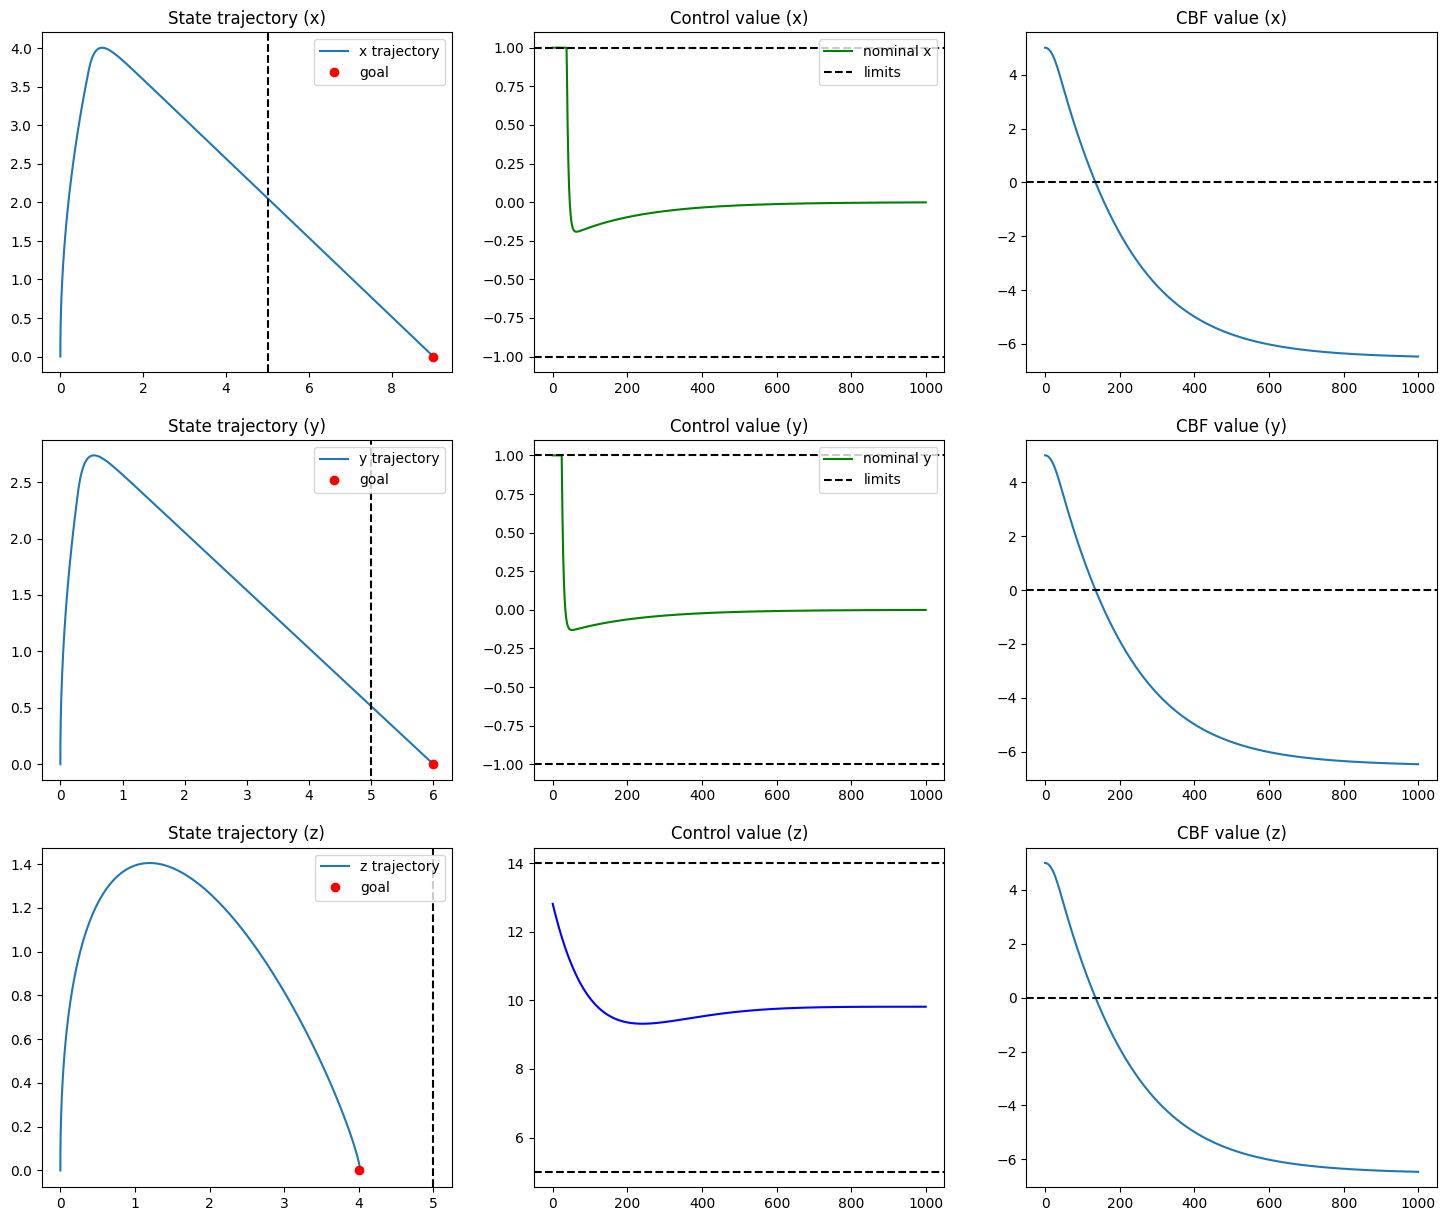

In [10]:
## CODE10p

fig, ax = plt.subplots(3, 3, figsize=(18, 15))

ax[0, 0].plot(states[:, 0], states[:, 3], label='x trajectory')  
ax[0, 0].plot(9, 0, 'ro', label='goal')  #change 6 to other loc for x
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_ylim()
ax[0, 0].vlines(5, ax[0, 0].get_ylim()[0], ax[0, 0].get_ylim()[1], color='k', linestyle="--")
ax[0, 0].set_title("State trajectory (x)")

ax[0, 1].plot(controls[:, 0], color='green', label='nominal x')
ax[0, 1].set_xlim()
ax[0, 1].hlines(dynamics.umin[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[0, 1].hlines(dynamics.umax[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--")
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_title("Control value (x)")

ax[0, 2].plot(vfs, label='CBF (x)')  
ax[0, 2].set_xlim()
ax[0, 2].hlines(0.0, ax[0, 2].get_xlim()[0], ax[0, 2].get_xlim()[1], color='k', linestyle="--")
ax[0, 2].set_title("CBF value (x)")

ax[1, 0].plot(states[:, 1], states[:, 4], label='y trajectory')  
ax[1, 0].plot(6, 0, 'ro', label='goal')   #change 6 to other loc for y
ax[1, 0].legend(loc='upper right')
ax[1, 0].set_ylim()
ax[1, 0].vlines(5, ax[0, 0].get_ylim()[0], ax[0, 0].get_ylim()[1], color='k', linestyle="--")
ax[1, 0].set_title("State trajectory (y)")

ax[1, 1].plot(controls[:, 1], color='green', label='nominal y')
ax[1, 1].set_xlim()
ax[1, 1].hlines(dynamics.umin[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[1, 1].hlines(dynamics.umax[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--")
ax[1, 1].legend(loc='upper right')
ax[1, 1].set_title("Control value (y)")

ax[1, 2].plot(vfs, label='CBF (y)')  
ax[1, 2].set_xlim()
ax[1, 2].hlines(0.0, ax[0, 2].get_xlim()[0], ax[0, 2].get_xlim()[1], color='k', linestyle="--")
ax[1, 2].set_title("CBF value (y)")

ax[2, 0].plot(states[:, 2], states[:, 5], label='z trajectory')  # z vs z_dot
ax[2, 0].plot(4, 0, 'ro', label='goal')  # Goal for z-component
ax[2, 0].legend(loc='upper right')
ax[2, 0].set_ylim()
ax[2, 0].vlines(5, ax[2, 0].get_ylim()[0], ax[2, 0].get_ylim()[1], color='k', linestyle="--")
ax[2, 0].set_title("State trajectory (z)")

ax[2, 1].plot(controls[:, 3], color='blue', label='nominal z')
ax[2, 1].set_xlim()
ax[2, 1].hlines(dynamics.umin[3], ax[2, 1].get_xlim()[0], ax[2, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[2, 1].hlines(dynamics.umax[3], ax[2, 1].get_xlim()[0], ax[2, 1].get_xlim()[1], color='k', linestyle="--")
ax[2, 1].set_title("Control value (z)")

ax[2, 2].plot(vfs, label='CBF')  # Assuming vfs includes z component values
ax[2, 2].set_xlim()
ax[2, 2].hlines(0.0, ax[2, 2].get_xlim()[0], ax[2, 2].get_xlim()[1], color='k', linestyle="--")
ax[2, 2].set_title("CBF value (z)")


In [11]:
## CODE11s
states = []
vfs = []
controls = []
qp_feasibles = []
state = starting_state
for t in range(1000):
    states.append(state)
    control, qp_feasible = safety_filter(state, nominal_control(state))
    controls.append(control)
    qp_feasibles.append(qp_feasible)
    vf = cbf.vf(state)
    vfs.append(vf)
    state = dynamics.step(state, control)
states = np.array(states)
vfs = np.array(vfs)
controls = np.array(controls)

Text(0.5, 1.0, 'CBF value (z)')

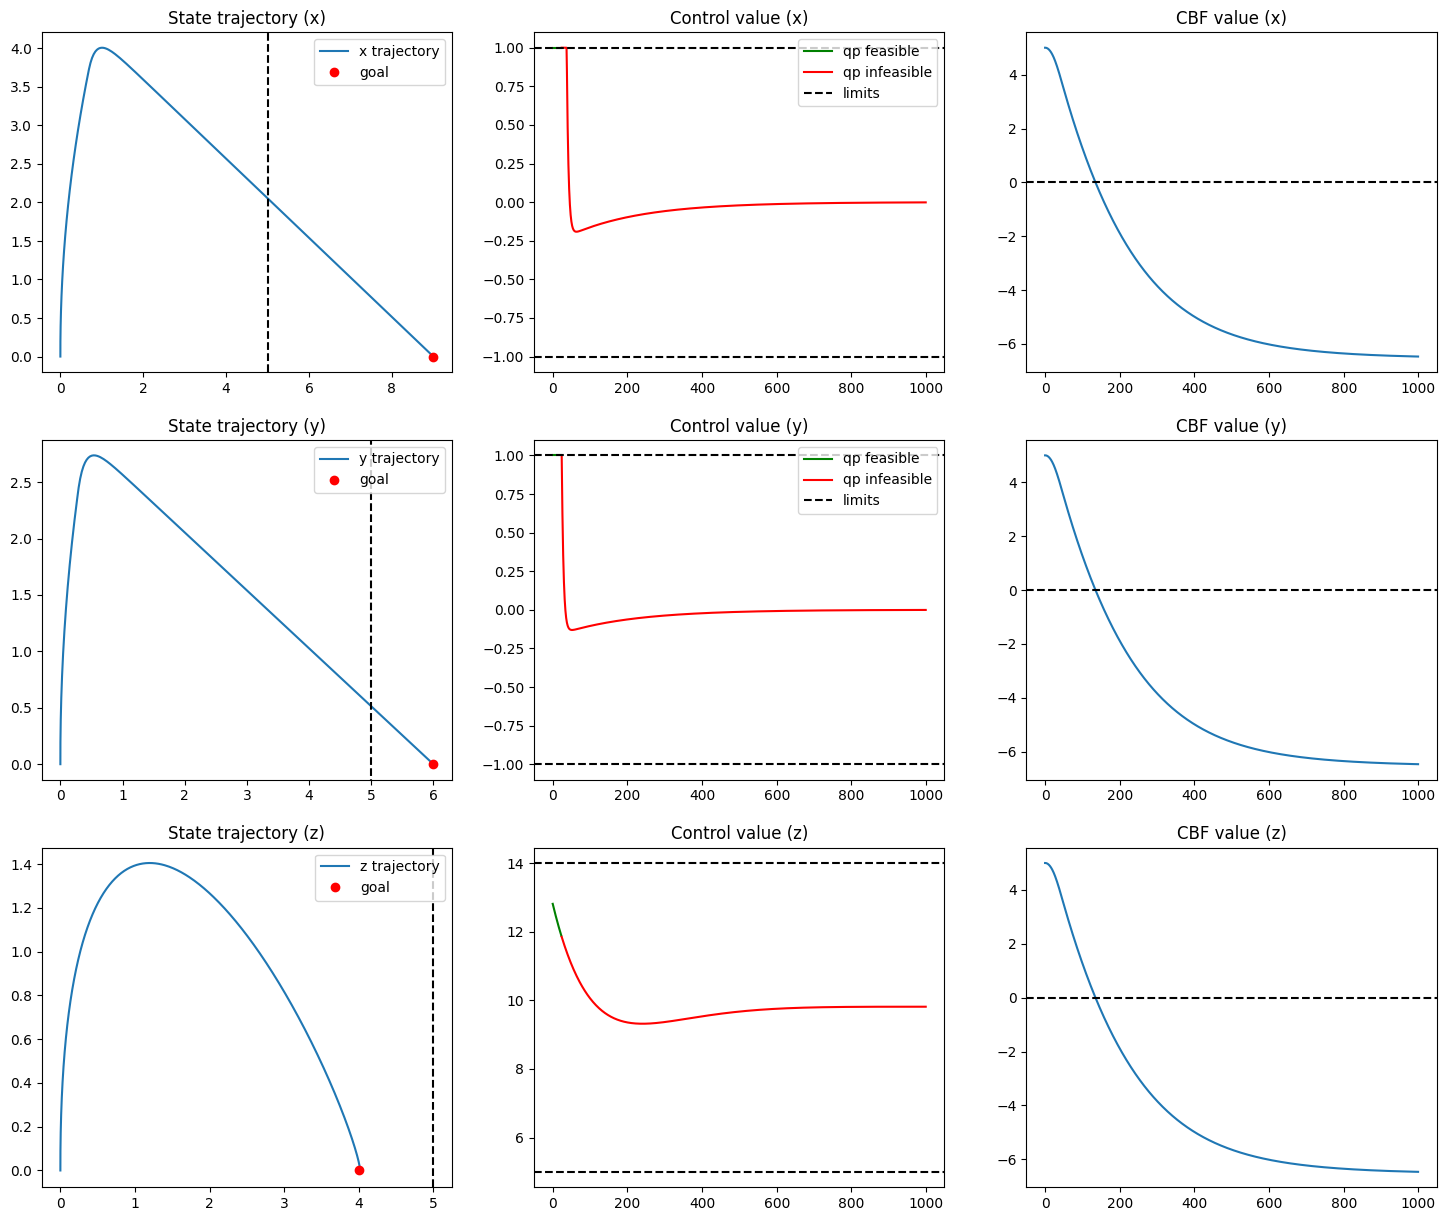

In [12]:
## CODE12s

fig, ax = plt.subplots(3, 3, figsize=(18, 15))

ax[0, 0].plot(states[:, 0], states[:, 3], label='x trajectory')  
ax[0, 0].plot(9, 0, 'ro', label='goal')  #x componenet
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_ylim()
ax[0, 0].vlines(5, ax[0, 0].get_ylim()[0], ax[0, 0].get_ylim()[1], color='k', linestyle="--")
ax[0, 0].set_title("State trajectory (x)")

controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,0])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,0])
ax[0,1].plot(controls_feasible, color='green', label='qp feasible')
ax[0,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[0, 1].set_xlim()
ax[0, 1].hlines(dynamics.umin[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[0, 1].hlines(dynamics.umax[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--")
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_title("Control value (x)")

ax[0, 2].plot(vfs, label='CBF (x)')  
ax[0, 2].set_xlim()
ax[0, 2].hlines(0.0, ax[0, 2].get_xlim()[0], ax[0, 2].get_xlim()[1], color='k', linestyle="--")
ax[0, 2].set_title("CBF value (x)")

ax[1, 0].plot(states[:, 1], states[:, 4], label='y trajectory')  
ax[1, 0].plot(6, 0, 'ro', label='goal')  #y componenet 
ax[1, 0].legend(loc='upper right')
ax[1, 0].set_ylim()
ax[1, 0].vlines(5, ax[0, 0].get_ylim()[0], ax[0, 0].get_ylim()[1], color='k', linestyle="--")
ax[1, 0].set_title("State trajectory (y)")

controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,1])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,1])
ax[1,1].plot(controls_feasible, color='green', label='qp feasible')
ax[1,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[1, 1].set_xlim()
ax[1, 1].hlines(dynamics.umin[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[1, 1].hlines(dynamics.umax[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--")
ax[1, 1].legend(loc='upper right')
ax[1, 1].set_title("Control value (y)")

ax[1, 2].plot(vfs, label='CBF (y)')  
ax[1, 2].set_xlim()
ax[1, 2].hlines(0.0, ax[0, 2].get_xlim()[0], ax[0, 2].get_xlim()[1], color='k', linestyle="--")
ax[1, 2].set_title("CBF value (y)")

ax[2, 0].plot(states[:, 2], states[:, 5], label='z trajectory')  # z vs z_dot
ax[2, 0].plot(4, 0, 'ro', label='goal')  # Goal for z-component
ax[2, 0].legend(loc='upper right')
ax[2, 0].set_ylim()
ax[2, 0].vlines(5, ax[2, 0].get_ylim()[0], ax[2, 0].get_ylim()[1], color='k', linestyle="--")
ax[2, 0].set_title("State trajectory (z)")

controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,3])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,3])
ax[2,1].plot(controls_feasible, color='green', label='qp feasible')
ax[2,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[2, 1].set_xlim()
ax[2, 1].hlines(dynamics.umin[3], ax[2, 1].get_xlim()[0], ax[2, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[2, 1].hlines(dynamics.umax[3], ax[2, 1].get_xlim()[0], ax[2, 1].get_xlim()[1], color='k', linestyle="--")
ax[2, 1].set_title("Control value (z)")

ax[2, 2].plot(vfs, label='CBF')  # Assuming vfs includes z component values
ax[2, 2].set_xlim()
ax[2, 2].hlines(0.0, ax[2, 2].get_xlim()[0], ax[2, 2].get_xlim()[1], color='k', linestyle="--")
ax[2, 2].set_title("CBF value (z)")


In [13]:
## CODE13s
controls_simple_cbf = controls

In [14]:
## CODE14s
dynamics = DoubleInt()
cbf = SmartCBF(dynamics)
safety_filter = SafetyFilter(cbf)

In [15]:
## CODE15s
states = []
vfs = []
controls = []
qp_feasibles = []
state = starting_state
for t in range(1000):
    states.append(state)
    control, qp_feasible = safety_filter(state, nominal_control(state))
    controls.append(control)
    qp_feasibles.append(qp_feasible)
    vf = cbf.vf(state)
    vfs.append(vf)
    state = dynamics.step(state, control)
states = np.array(states)
vfs = np.array(vfs)
controls = np.array(controls)

Text(0.5, 1.0, 'CBF value (z)')

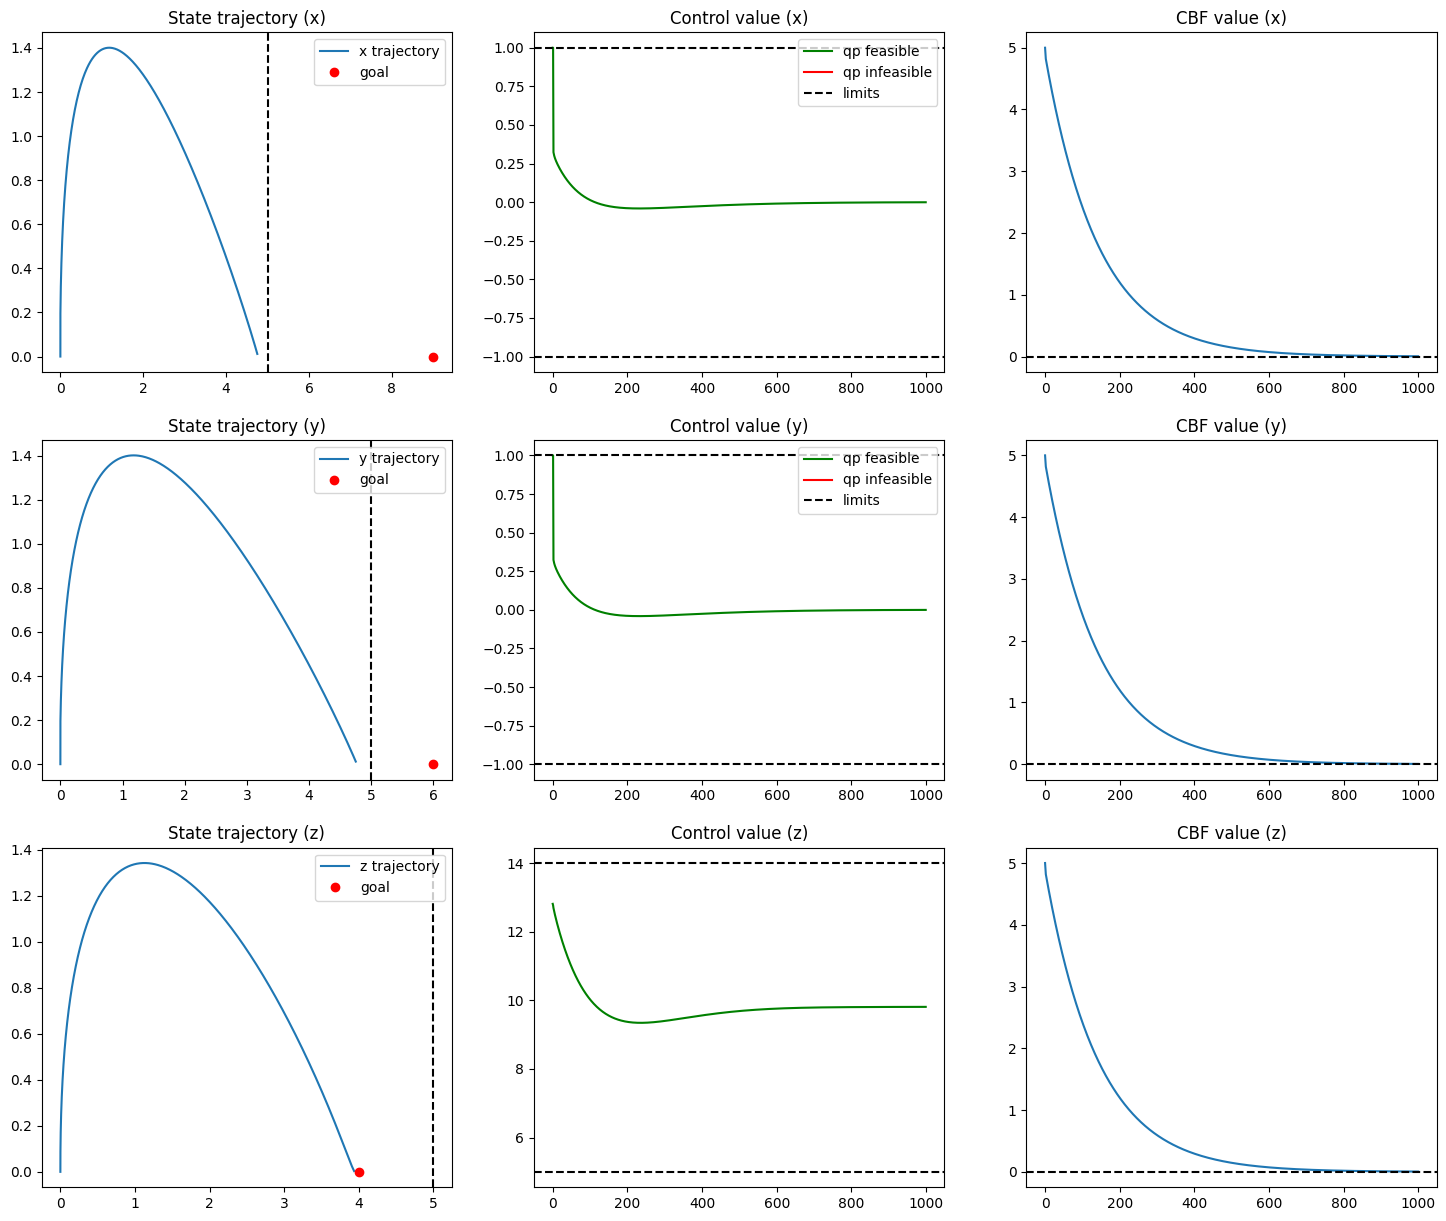

In [16]:
## CODE16s

fig, ax = plt.subplots(3, 3, figsize=(18, 15))

ax[0, 0].plot(states[:, 0], states[:, 3], label='x trajectory')  
ax[0, 0].plot(9, 0, 'ro', label='goal')  
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_ylim()
ax[0, 0].vlines(5, ax[0, 0].get_ylim()[0], ax[0, 0].get_ylim()[1], color='k', linestyle="--")
ax[0, 0].set_title("State trajectory (x)")

controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,0])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,0])
ax[0,1].plot(controls_feasible, color='green', label='qp feasible')
ax[0,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[0, 1].set_xlim()
ax[0, 1].hlines(dynamics.umin[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[0, 1].hlines(dynamics.umax[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--")
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_title("Control value (x)")

ax[0, 2].plot(vfs, label='CBF (x)')  
ax[0, 2].set_xlim()
ax[0, 2].hlines(0.0, ax[0, 2].get_xlim()[0], ax[0, 2].get_xlim()[1], color='k', linestyle="--")
ax[0, 2].set_title("CBF value (x)")

ax[1, 0].plot(states[:, 1], states[:, 4], label='y trajectory')  
ax[1, 0].plot(6, 0, 'ro', label='goal')  
ax[1, 0].legend(loc='upper right')
ax[1, 0].set_ylim()
ax[1, 0].vlines(5, ax[0, 0].get_ylim()[0], ax[0, 0].get_ylim()[1], color='k', linestyle="--")
ax[1, 0].set_title("State trajectory (y)")

controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,1])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,1])
ax[1,1].plot(controls_feasible, color='green', label='qp feasible')
ax[1,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[1, 1].set_xlim()
ax[1, 1].hlines(dynamics.umin[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[1, 1].hlines(dynamics.umax[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--")
ax[1, 1].legend(loc='upper right')
ax[1, 1].set_title("Control value (y)")

ax[1, 2].plot(vfs, label='CBF (y)')  
ax[1, 2].set_xlim()
ax[1, 2].hlines(0.0, ax[0, 2].get_xlim()[0], ax[0, 2].get_xlim()[1], color='k', linestyle="--")
ax[1, 2].set_title("CBF value (y)")

ax[2, 0].plot(states[:, 2], states[:, 5], label='z trajectory')  # z vs z_dot
ax[2, 0].plot(4, 0, 'ro', label='goal')  # Goal for z-component
ax[2, 0].legend(loc='upper right')
ax[2, 0].set_ylim()
ax[2, 0].vlines(5, ax[2, 0].get_ylim()[0], ax[2, 0].get_ylim()[1], color='k', linestyle="--")
ax[2, 0].set_title("State trajectory (z)")

controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,3])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,3])
ax[2,1].plot(controls_feasible, color='green', label='qp feasible')
ax[2,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[2, 1].set_xlim()
ax[2, 1].hlines(dynamics.umin[3], ax[2, 1].get_xlim()[0], ax[2, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[2, 1].hlines(dynamics.umax[3], ax[2, 1].get_xlim()[0], ax[2, 1].get_xlim()[1], color='k', linestyle="--")
ax[2, 1].set_title("Control value (z)")

ax[2, 2].plot(vfs, label='CBF')  # Assuming vfs includes z component values
ax[2, 2].set_xlim()
ax[2, 2].hlines(0.0, ax[2, 2].get_xlim()[0], ax[2, 2].get_xlim()[1], color='k', linestyle="--")
ax[2, 2].set_title("CBF value (z)")


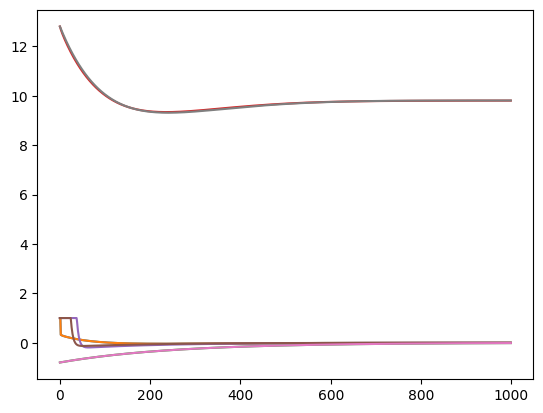

In [17]:
## CODE17s 
plt.plot(controls, label='Smart CBF')
plt.plot(controls_simple_cbf, label='Simple CBF')